In [1]:
import pandas as pd
import numpy as np
import re
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Gensim
import gensim
from gensim.utils import simple_preprocess
# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from collections import Counter
from wordcloud import WordCloud
#Spacy parser
import spacy
nlp = spacy.load("en_core_web_sm")

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

## Load data

In [2]:
hs = pd.read_csv("./TempData/model_data.csv")

mlma = pd.read_csv("./TempData/mlma_dataset.csv")

hasoc = pd.read_csv("./TempData/hasoc2019_data.csv",delimiter="\t")

df = pd.concat([hs,mlma, hasoc], axis=0, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11654 entries, 0 to 11653
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  11654 non-null  object
 1   text        11654 non-null  object
 2   label       11654 non-null  object
dtypes: object(3)
memory usage: 273.3+ KB


## Drop Duplicates

In [3]:
df.drop_duplicates(subset=['text'], keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10321 entries, 0 to 10500
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10321 non-null  object
 1   text        10321 non-null  object
 2   label       10321 non-null  object
dtypes: object(3)
memory usage: 322.5+ KB


## Descriptive statistics

In [4]:
count = df['text'].str.split().str.len()
count.index = count.index.astype(str) + ' words:'
print("Total number of words:", count.sum(), "words")


Total number of words: 127020 words


In [5]:
print("Mean number of words per tweet:", round(count.mean(), 2),'words')

Mean number of words per tweet: 12.31 words


In [6]:
df['tweet_length'] = df['text'].str.len()
print("Total length of the dataset is:",df.tweet_length.sum(), "characters")

Total length of the dataset is: 781347 characters


In [7]:
print("Mean length of a tweet is:", round(df.tweet_length.mean(),0),'characters')

Mean length of a tweet is: 76.0 characters


# Feature engineering (before exclusion of a few important data)

In [8]:
def has_element(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    new_tweet = None
    for i in r:
        new_tweet = re.sub(i, '', tweet)
    
    if new_tweet and new_tweet != tweet:
        return True
    r = re.findall(pattern2, tweet)
    for i in r:
        new_tweet = re.sub(i, '', tweet)
    if new_tweet and new_tweet != tweet:
        return True
    return False


In [9]:
df["has_user"] = np.vectorize(has_element)(df['text'], "@ [\w]*", "@[\w]*")

In [10]:
df["has_hashtag"] = np.vectorize(has_element)(df['text'], "# [\w]*", "#[\w]*")

In [11]:
df["has_url"] = np.vectorize(has_element)(df['text'], r"http\S+", r"http\S+")

## Remove @users
Twitter enables including usernames within tweets through the symbol “@.” These do not possess any value for our analysis; hence they are removed from the dataset using a function.

In [12]:
def remove_users(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
  
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet
df['tidy_tweet'] = np.vectorize(remove_users)(df['text'],     "@ [\w]*", "@[\w]*")
df.head()

,Unnamed: 0,text,label,tweet_length,has_user,has_hashtag,has_url,tidy_tweet
0,0,These girls are the equivalent of the irritati...,racism,99,False,True,False,These girls are the equivalent of the irritati...
1,1,Who is writing the bimbolines? #mkr,sexism,35,False,True,False,Who is writing the bimbolines? #mkr
2,2,"Colin will save them. They're pretty blondes, ...",sexism,75,False,True,False,"Colin will save them. They're pretty blondes, ..."
3,3,Which will end first: #mkr or Tony Abbott as PM?,none,48,False,True,False,Which will end first: #mkr or Tony Abbott as PM?
4,4,RT @TheAngelaOfOz: That's bullshit Colin and y...,none,62,True,True,False,RT : That's bullshit Colin and you know it. #mkr


## lowercase normalization

In [13]:
df['tidy_tweet'] = df['tidy_tweet'].str.lower()

## Remove hashtags (#)
Same as with usernames, hashtags also are considered not of significant value for topic modeling analysis, in particular, therefore, are removed.

** seria bom ver quais as hashtags mais frequentes **

In [14]:
df['tidy_tweet'] = np.vectorize(remove_users)(df['tidy_tweet'], "# [\w]*", "#[\w]*")
df.head(10)

,Unnamed: 0,text,label,tweet_length,has_user,has_hashtag,has_url,tidy_tweet
0,0,These girls are the equivalent of the irritati...,racism,99,False,True,False,these girls are the equivalent of the irritati...
1,1,Who is writing the bimbolines? #mkr,sexism,35,False,True,False,who is writing the bimbolines?
2,2,"Colin will save them. They're pretty blondes, ...",sexism,75,False,True,False,"colin will save them. they're pretty blondes, ..."
3,3,Which will end first: #mkr or Tony Abbott as PM?,none,48,False,True,False,which will end first: or tony abbott as pm?
4,4,RT @TheAngelaOfOz: That's bullshit Colin and y...,none,62,True,True,False,rt : that's bullshit colin and you know it.
5,5,Drasko they didn't cook half a bird you idiot ...,racism,50,False,True,False,drasko they didn't cook half a bird you idiot
9,9,Stop saying dumb blondes with pretty faces as ...,sexism,94,False,True,False,stop saying dumb blondes with pretty faces as ...
10,10,Obviously natural blondes!! #mkr,sexism,32,False,True,False,obviously natural blondes!!
11,11,R u fucking kidding - catwalk - all that's mis...,sexism,65,False,True,False,r u fucking kidding - catwalk - all that's mis...
12,12,I'm done - won't bother with the rest of this ...,none,69,False,True,False,i'm done - won't bother with the rest of this ...


## Remove links


In [15]:
def remove_links(tweet):
    tweet_no_link = re.sub(r"http\S+", "", tweet)
    return tweet_no_link
df['tidy_tweet'] = np.vectorize(remove_links)(df['tidy_tweet'])

## remove punctuations, numbers, special characters and short words

In [16]:
# REMOVE Punctuations, Numbers, and Special Characters
df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

# REMOVE SHORT WORDS
df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))

## words replaces

In [17]:
# retard and retarded
df['tidy_tweet'] = df['tidy_tweet'].str.replace("retarded", "retard")

## Lemmatization
An essential step of pre-processing is known as Tokenization. It is the process where the text is split according to whitespaces, and every word and punctuation is saved as a separate token. We perform this step by using spacy parser.

Proper nouns are also removed at this point


In [18]:
def tokenize_spacy(tweet):
    for text in tweet:
        doc = nlp(text)
        filtered_sentence = [t.lemma_ for t in doc if t.pos_ not in ["PUNCT",'PROPN',"PRON"]] # remove proper nouns and pronouns
        # pe
        yield(filtered_sentence) 

df['tidy_tweet_tokens'] = list(tokenize_spacy(df['tidy_tweet']))
df.head()


,Unnamed: 0,text,label,tweet_length,has_user,has_hashtag,has_url,tidy_tweet,tidy_tweet_tokens
0,0,These girls are the equivalent of the irritati...,racism,99,False,True,False,these girls equivalent irritating asian girls ...,"[these, girl, equivalent, irritate, asian, gir..."
1,1,Who is writing the bimbolines? #mkr,sexism,35,False,True,False,writing bimbolines,"[writing, bimboline]"
2,2,"Colin will save them. They're pretty blondes, ...",sexism,75,False,True,False,colin will save them they pretty blondes they ...,"[will, save, pretty, blonde, keep, tell]"
3,3,Which will end first: #mkr or Tony Abbott as PM?,none,48,False,True,False,which will first tony abbott,"[which, will, first]"
4,4,RT @TheAngelaOfOz: That's bullshit Colin and y...,none,62,True,True,False,that bullshit colin know,[that]


## Remove stopwords

Next, we remove stopwords that have no analytic value, usually articles, prepositions, or pronouns, for instance, ‘a,’ ‘and,’ ‘the,’ etc. The default list can be adjusted and extended as desired. We added some new words to the predefined list of Natural Language Toolkit (NLTK), which contains 179 words.

In [19]:
# Prepare Stop Words
stop_words = stopwords.words('english')
stop_words.extend([ 'https', 'twitter', 'rt', 'pic','twitt','amp','pron'])# REMOVE STOPWORDS

def remove_stopwords(tweets):
    return [[word for word in simple_preprocess(str(tweet)) if word    not in stop_words] for tweet in tweets]

df['tokens_no_stop'] = remove_stopwords(df['tidy_tweet_tokens'])
df.head(10)

,Unnamed: 0,text,label,tweet_length,has_user,has_hashtag,has_url,tidy_tweet,tidy_tweet_tokens,tokens_no_stop
0,0,These girls are the equivalent of the irritati...,racism,99,False,True,False,these girls equivalent irritating asian girls ...,"[these, girl, equivalent, irritate, asian, gir...","[girl, equivalent, irritate, asian, girl, coup..."
1,1,Who is writing the bimbolines? #mkr,sexism,35,False,True,False,writing bimbolines,"[writing, bimboline]","[writing, bimboline]"
2,2,"Colin will save them. They're pretty blondes, ...",sexism,75,False,True,False,colin will save them they pretty blondes they ...,"[will, save, pretty, blonde, keep, tell]","[save, pretty, blonde, keep, tell]"
3,3,Which will end first: #mkr or Tony Abbott as PM?,none,48,False,True,False,which will first tony abbott,"[which, will, first]",[first]
4,4,RT @TheAngelaOfOz: That's bullshit Colin and y...,none,62,True,True,False,that bullshit colin know,[that],[]
5,5,Drasko they didn't cook half a bird you idiot ...,racism,50,False,True,False,drasko they didn cook half bird idiot,[idiot],[idiot]
9,9,Stop saying dumb blondes with pretty faces as ...,sexism,94,False,True,False,stop saying dumb blondes with pretty faces nee...,"[stop, say, dumb, blonde, with, pretty, face, ...","[stop, say, dumb, blonde, pretty, face, need, ..."
10,10,Obviously natural blondes!! #mkr,sexism,32,False,True,False,obviously natural blondes,"[obviously, natural, blonde]","[obviously, natural, blonde]"
11,11,R u fucking kidding - catwalk - all that's mis...,sexism,65,False,True,False,fucking kidding catwalk that missing pole,"[fuck, kid, catwalk, that, miss, pole]","[fuck, kid, catwalk, miss, pole]"
12,12,I'm done - won't bother with the rest of this ...,none,69,False,True,False,done bother with rest this pathetic shit show,"[do, bother, with, rest, this, pathetic, shit,...","[bother, rest, pathetic, shit, show]"


## REMOVE TWEETS LESS THAN 3 TOKENS
For topic modeling and also sentiment analysis, documents with less than three tokens are not suitable to generate enough information.

In [20]:
df['length'] = df['tokens_no_stop'].apply(len)
df = df.drop(df[df['length']<3].index)
df = df.drop(['length'], axis=1)
df.shape
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7106 entries, 0 to 7105
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         7106 non-null   object
 1   text               7106 non-null   object
 2   label              7106 non-null   object
 3   tweet_length       7106 non-null   int64 
 4   has_user           7106 non-null   bool  
 5   has_hashtag        7106 non-null   bool  
 6   has_url            7106 non-null   bool  
 7   tidy_tweet         7106 non-null   object
 8   tidy_tweet_tokens  7106 non-null   object
 9   tokens_no_stop     7106 non-null   object
dtypes: bool(3), int64(1), object(6)
memory usage: 409.6+ KB


## Word Clouds
### All tweets

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7106 entries, 0 to 7105
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         7106 non-null   object
 1   text               7106 non-null   object
 2   label              7106 non-null   object
 3   tweet_length       7106 non-null   int64 
 4   has_user           7106 non-null   bool  
 5   has_hashtag        7106 non-null   bool  
 6   has_url            7106 non-null   bool  
 7   tidy_tweet         7106 non-null   object
 8   tidy_tweet_tokens  7106 non-null   object
 9   tokens_no_stop     7106 non-null   object
dtypes: bool(3), int64(1), object(6)
memory usage: 409.6+ KB


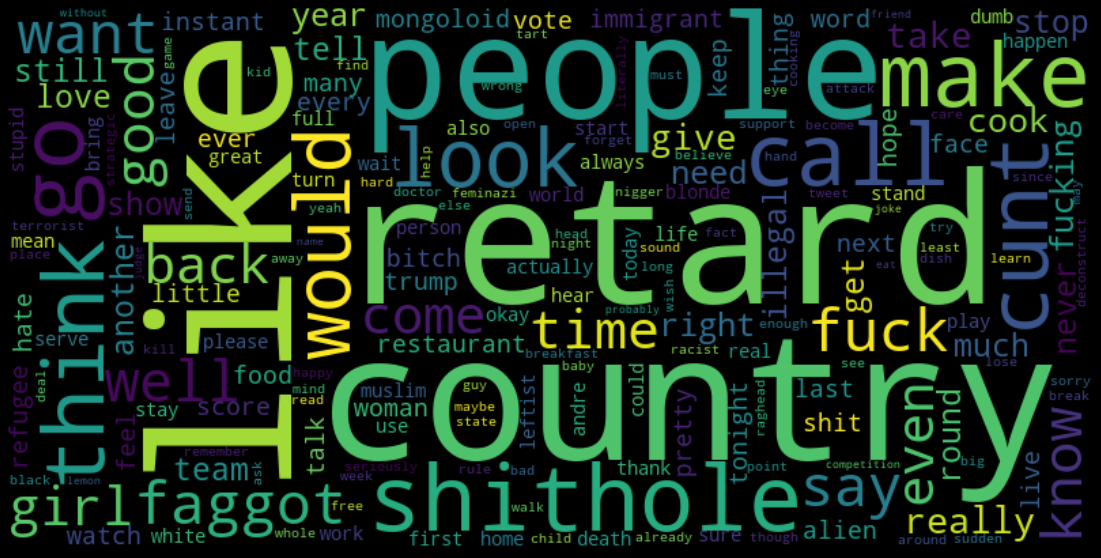

In [21]:
flat_list = [item for sublist in df['tokens_no_stop'].values for item in sublist]

wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(Counter(flat_list))

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
df.info()

### Offensive


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3975 entries, 0 to 7092
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3975 non-null   object
 1   text               3975 non-null   object
 2   label              3975 non-null   object
 3   tweet_length       3975 non-null   int64 
 4   has_user           3975 non-null   bool  
 5   has_hashtag        3975 non-null   bool  
 6   has_url            3975 non-null   bool  
 7   tidy_tweet         3975 non-null   object
 8   tidy_tweet_tokens  3975 non-null   object
 9   tokens_no_stop     3975 non-null   object
dtypes: bool(3), int64(1), object(6)
memory usage: 260.1+ KB


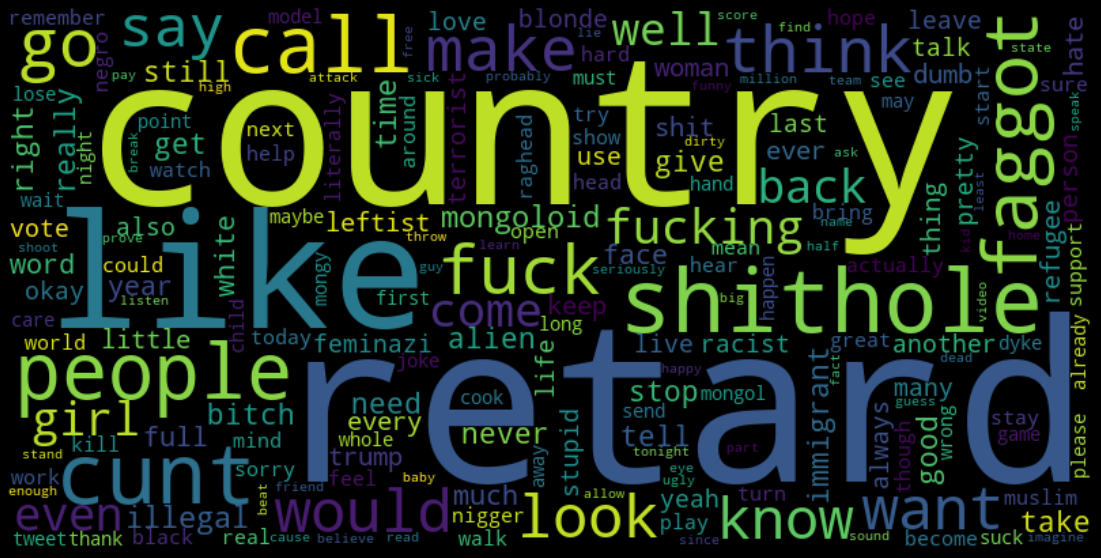

In [22]:
offensive_df = df[~df.label.isin(['none','normal','NOT'])]
flat_list = [item for sublist in offensive_df['tokens_no_stop'].values for item in sublist]

wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(Counter(flat_list))

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
offensive_df.info()

## Not Offensive


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3131 entries, 5 to 7105
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3131 non-null   object
 1   text               3131 non-null   object
 2   label              3131 non-null   object
 3   tweet_length       3131 non-null   int64 
 4   has_user           3131 non-null   bool  
 5   has_hashtag        3131 non-null   bool  
 6   has_url            3131 non-null   bool  
 7   tidy_tweet         3131 non-null   object
 8   tidy_tweet_tokens  3131 non-null   object
 9   tokens_no_stop     3131 non-null   object
dtypes: bool(3), int64(1), object(6)
memory usage: 204.9+ KB


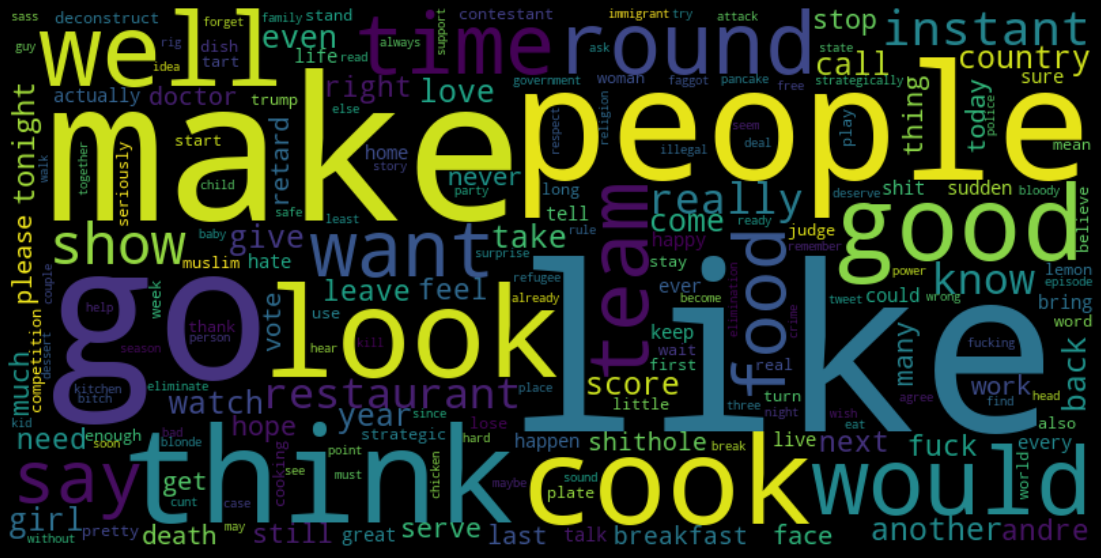

In [23]:
offensive_df = df[df.label.isin(['none','normal','NOT'])]
flat_list = [item for sublist in offensive_df['tokens_no_stop'].values for item in sublist]

wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(Counter(flat_list))

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
offensive_df.info()

In [24]:
df.to_pickle("./TempData/preprocessed")

In [25]:
flat_list = [item for sublist in df['tokens_no_stop'].values for item in sublist]
c = Counter(flat_list)
c.most_common(5)

[('like', 660),
 ('retard', 558),
 ('country', 536),
 ('people', 418),
 ('shithole', 391)]

In [26]:
df[['text','tokens_no_stop']]

,text,tokens_no_stop
0,These girls are the equivalent of the irritati...,"[girl, equivalent, irritate, asian, girl, coup..."
1,"Colin will save them. They're pretty blondes, ...","[save, pretty, blonde, keep, tell]"
2,Stop saying dumb blondes with pretty faces as ...,"[stop, say, dumb, blonde, pretty, face, need, ..."
3,Obviously natural blondes!! #mkr,"[obviously, natural, blonde]"
4,R u fucking kidding - catwalk - all that's mis...,"[fuck, kid, catwalk, miss, pole]"
...,...,...
7101,Each of the divorce must be pronounced with a ...,"[divorce, must, pronounce, stipulate, interval..."
7102,He is 62-yr-old Harswaroop Chauhan. His only s...,"[sible, gangaram, lynch, poor, responsibility,..."
7103,"Peace of graveyard or peace of mind, @asadowai...","[peace, peace, mind, ask]"
7104,The humble #tribute on the sacrifice day of #J...,"[humble, sacrifice, symbolizing, unbelievable,..."
